# Projected outcomes

This notebook contains the code we used to project outcomes under the 10x5 and 50x1 districting plans using demographic threshold inference model (see section 5 of the report).

In [1]:
import pandas
import numpy
from collections import namedtuple
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
import itertools

## Projection model code

In [2]:
class ElectionSampler:
    def __init__(self, cases, threshold):
        self.cases = cases
        self.threshold = threshold

    def decide_case(self, groups: pandas.Series):
        number_over_threshold = (groups > self.threshold).sum()
        return self.cases[number_over_threshold]

    def sample(self, groups: pandas.Series):
        """
        :param pandas.Series groups: a single row of a DataFrame with the percentages
            of each racial group in a ward.
        """
        outcomes, probabilities = self.decide_case(groups)
        outcome_index = numpy.random.choice(a=numpy.arange(len(outcomes)), p=probabilities)
        outcome = outcomes[outcome_index]
        groups_from_highest_to_lowest = groups.sort_values(ascending=False).keys()
        full_outcome = itertools.chain(
            outcome,
            itertools.repeat(0, len(groups_from_highest_to_lowest) - len(outcome))
        )
        return pandas.Series(full_outcome, index=groups_from_highest_to_lowest)


class ElectionSamplerWithMajority(ElectionSampler):
    def decide_case(self, groups: pandas.Series):
        number_over_threshold = (groups > self.threshold).sum()
        any_majority = (groups > 0.5).any()
        if any_majority and number_over_threshold in self.cases["majority"]:
            return self.cases["majority"][number_over_threshold]
        else:
            return self.cases["plurality"][number_over_threshold]


In [3]:
class Case:
    def __init__(self, outcomes, probabilities):
        assert len(outcomes) == len(probabilities)
        assert all(isinstance(x, tuple) for x in outcomes)
        assert 0.99 <= sum(probabilities) <= 1.01
        self.outcomes = outcomes
        self.probabilities = numpy.reshape(numpy.asarray(probabilities), len(probabilities))
    
    def __iter__(self):
        return iter((self.outcomes, self.probabilities))

In [4]:
fifty_by_one = ElectionSamplerWithMajority(
    cases = {
        "majority": {
            1: Case([(1,0), (0,1)], (0.98, 0.02)),
            2: Case([(1,0,0), (0,1,0), (0,0,1)], (0.8, 0.18, 0.02)),
        },
        "plurality": {
            1: Case([(1,0,0), (0,1,0), (0,0,1)], (0.8, 0.18, 0.02)),
            2: Case([(1,0,0), (0,1,0), (0,0,1)], (0.60, 0.30, 0.10)),
            3: Case([(1,0,0), (0,1,0), (0,0,1)], (0.50, 0.30, 0.20)),    
        }
    },
    threshold = 0.25
)

In [5]:
cases = {
    "majority": {
        1: Case([(5,0),(4,1)], (0.60, 0.40)),
        2: Case([(4, 1), (3, 2), (2, 3), (3, 1, 1), (2,2, 1)], 
                (.60, .30 , .05,  .03,  .02)),
        3: Case([(3, 1, 1), (2,2,1), (2,1,2)], (.6, 0.3, 0.1))
    },
    "plurality": {
        1: Case([(5,0), (4,1), (4,0,1), (3,1,1)], (0.5, 0.4, 0.05, 0.05)),
        2: Case([(4,1), (3,2), (2,3), (3,1,1), (2,2,1)],
               (0.5, 0.35, 0.1, 0.03, 0.02)),
        3: Case([(3, 1, 1), (2,2,1), (2,1,2)], (.5, 0.35, 0.15)),
        4: Case([(2, 1, 1, 1), (1, 2,1,1), (1,1,2,1)], (.5, 0.35, 0.15))
    }
}

ten_by_five = ElectionSamplerWithMajority(
    cases=cases,
    threshold = 1/6
)

In [6]:
cases = {
    "majority": {
        1: Case([(3,0,0), (2,1,0), (2,0,1)], (0.9, 0.08, 0.02)),
        2: Case([(3,0,0), (2,1,0), (1,2,0), (1,1,1)], (0.1, 0.7, 0.15, 0.05)),
    },
    "plurality": {
        1: Case([(3,0,0), (2,1,0), (2,0,1)], (0.6, 0.38, 0.02)),
        2: Case([(3,0,0), (2,1,0), (1,2,0), (1,1,1)], (0.05, 0.65, 0.25, 0.05)),
        3: Case([(3,0,0), (2,1,0), (2,0,1), (1,2,0), (1,1,1)],
                (0.02, 0.05, 0.02, 0.01, 0.90)),
    }
}

ten_by_three = ElectionSamplerWithMajority(cases, threshold=0.25)

In [7]:
def load_data(filename):
    df = pandas.read_csv(filename)
    data = pandas.DataFrame(
        {
            "step": df["step"],
            "ward": df["ward"],
            "White": df["NH_WHITE"] / df["TOTPOP"],
            "Black": df["NH_BLACK"] / df["TOTPOP"],
            "Hispanic": df["HISP"] / df["TOTPOP"],
            "Asian": df["NH_ASIAN"] / df["TOTPOP"],
        }
    )
    return data

## Generating the projections

In [8]:
def random_sample(data, size, sampler):
    all_plans = {step: data.loc[indices] for step, indices in data.groupby("step").groups.items()}
    groups = ["White", "Black", "Hispanic", "Asian"]
    plan_indices = data["step"].unique()
    
    if size == len(plan_indices):
        sample = plan_indices
    else:
        sample = numpy.random.choice(plan_indices, size=size)
    
    for plan_index in tqdm(sample):
        wards = all_plans[plan_index]
        yield wards[groups].apply(sampler.sample, axis=1).sum()

In [9]:
groups = ["Asian", "Black", "Hispanic", "White"]

In [23]:
data = load_data("../ensembles/prec50/results.csv")

In [11]:
data = load_data("../ensembles/prec50/results.csv")
outcomes_prec50 = pandas.DataFrame.from_records(random_sample(data, data.step.nunique(), fifty_by_one))
outcomes_prec50.to_csv("./projection_50x1.csv")
outcomes_prec50.groupby(groups).size().to_csv("./projection_50x1_counts.csv", header=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [11:10<00:00, 14.89it/s]


In [ ]:
data = load_data("../ensembles/prec10/results.csv")
outcomes_prec10_by_5 = pandas.DataFrame.from_records(random_sample(data, data.step.nunique(), ten_by_five))
outcomes_prec10_by_5.to_csv("./projection_10x5.csv")
outcomes_prec10_by_5.groupby(groups).size().to_csv("./projection_10x5_counts.csv", header=True)

outcomes_prec10_by_3 = pandas.DataFrame.from_records(random_sample(data, data.step.nunique(), ten_by_three))
outcomes_prec10_by_3.to_csv("./projection_10x3.csv")
outcomes_prec10_by_3.groupby(groups).size().to_csv("./projection_10x5_counts.csv", header=True)

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 94958/100000 [27:05<01:21, 62.19it/s]

In [15]:
data = load_data("../ensembles/ca10/results.csv")
outcomes_ca10_by_5 = pandas.DataFrame.from_records(random_sample(data, data.step.nunique(), ten_by_five))
outcomes_ca10_by_5.to_csv("./projection_10x5_CA.csv")
outcomes_ca10_by_5.groupby(groups).size().to_csv("./projection_10x5_CA_counts.csv", header=True)

outcomes_ca10_by_3 = pandas.DataFrame.from_records(random_sample(data, data.step.nunique(), ten_by_three))
outcomes_ca10_by_3.to_csv("./projection_10x3_CA.csv")
outcomes_ca10_by_3.groupby(groups).size().to_csv("./projection_10x3_CA_counts.csv", header=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [29:49<00:00, 55.26it/s]


## Plotting the results

Here's an example plot of the projections we just made using the 50x1 ensemble.

In [37]:
def plot_hist(csv_file, save_as, upper_bound=30):
    data = pandas.read_csv(csv_file)
    fig, axes = plt.subplots(2, 2, figsize=(12,10))
    groups = ["Asian", "Black", "Hispanic", "White"]
    for ax, group in zip(axes.ravel(), groups):
        data[group].hist(
            color="#0099cd",
            bins=list(range(upper_bound)),
            ax=ax,
            grid=True
        )
        ax.set_xticks(list(x + 0.5 for x in range(0, upper_bound, 5)))
        ax.set_xticklabels(list(str(x) for x in range(0, upper_bound, 5)))
        ax.set_title(group)
    plt.savefig(save_as)
    plt.show()
    return fig, axes

In [35]:
def plot_hist_superimposed(csv_file, save_as, upper_bound=30):
    data = pandas.read_csv(csv_file)
    fig, ax = plt.subplots()
    groups = ["Black", "Hispanic", "White", "Asian"]
    data[groups].plot.hist(
        figsize=(12,10),
        bins=list(range(upper_bound)),
        ax=ax,
        alpha=0.5,
        grid=True
    )
    ax.set_xticks(list(x + 0.5 for x in range(0, upper_bound, 5)))
    ax.set_xticklabels(list(str(x) for x in range(0, upper_bound, 5)))
    plt.savefig(save_as)
    plt.show()
    return fig, ax

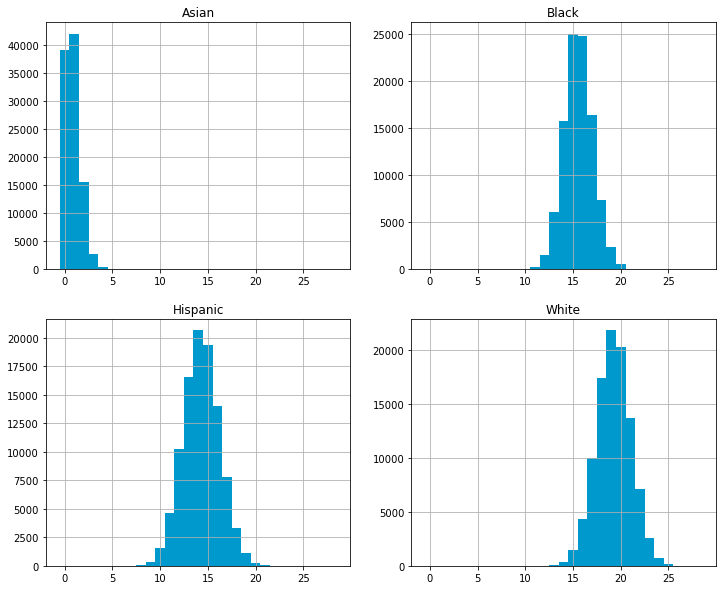

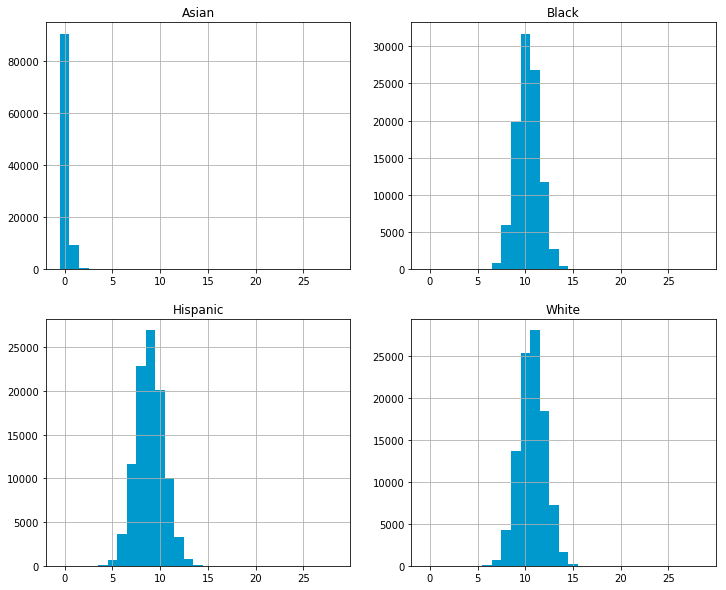

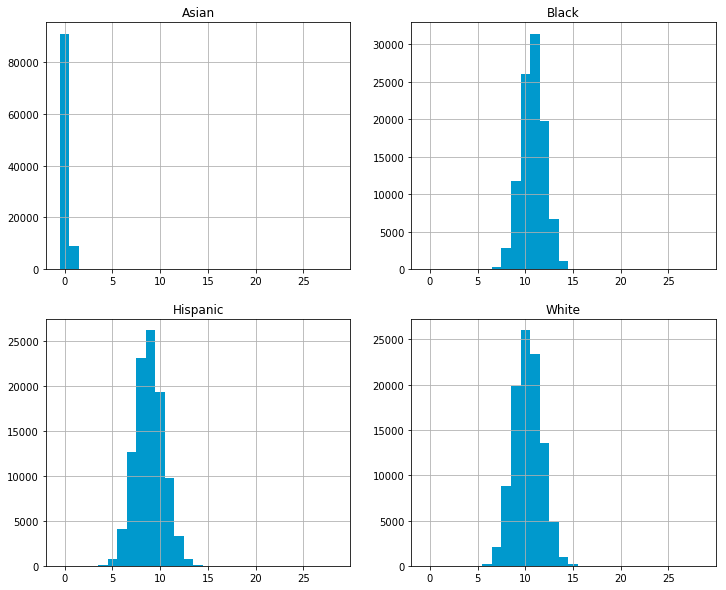

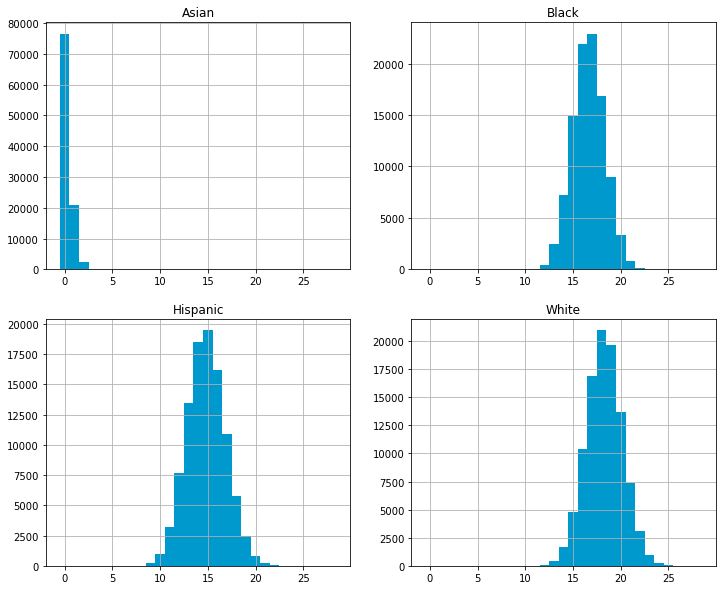

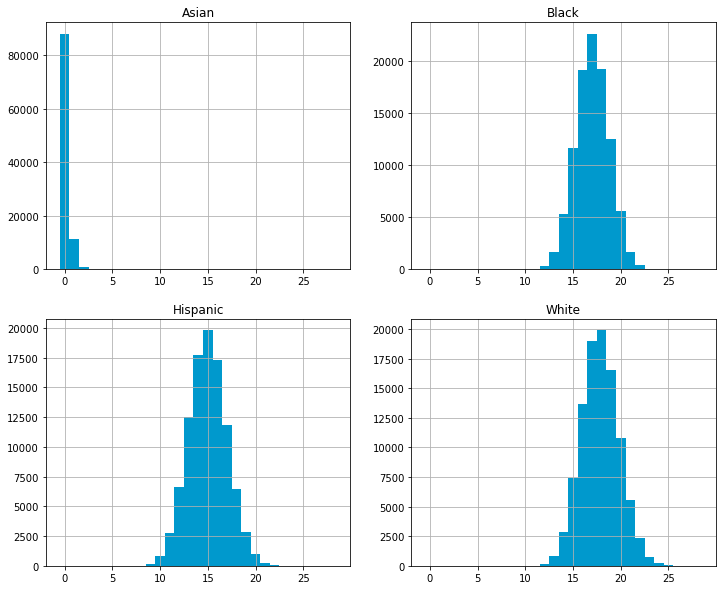

(<Figure size 864x720 with 4 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000023B69225A58>,
       dtype=object))

In [38]:
plot_hist("./projection_50x1.csv", "./50x1_hist.png")
plot_hist("./projection_10x3.csv", "./10x3_hist.png")
plot_hist("./projection_10x3_CA.csv", "./10x3_CA_hist.png")
plot_hist("./projection_10x5.csv", "./10x5_hist.png")
plot_hist("./projection_10x5_CA.csv", "./10x5_CA_hist.png")

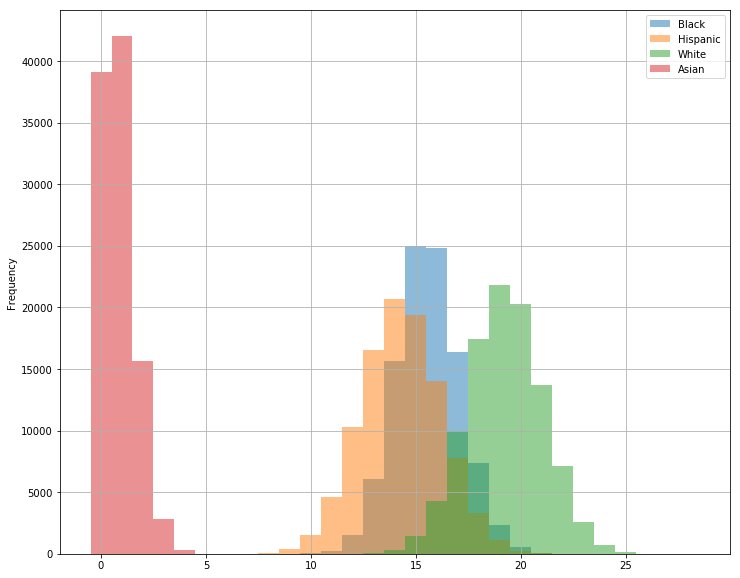

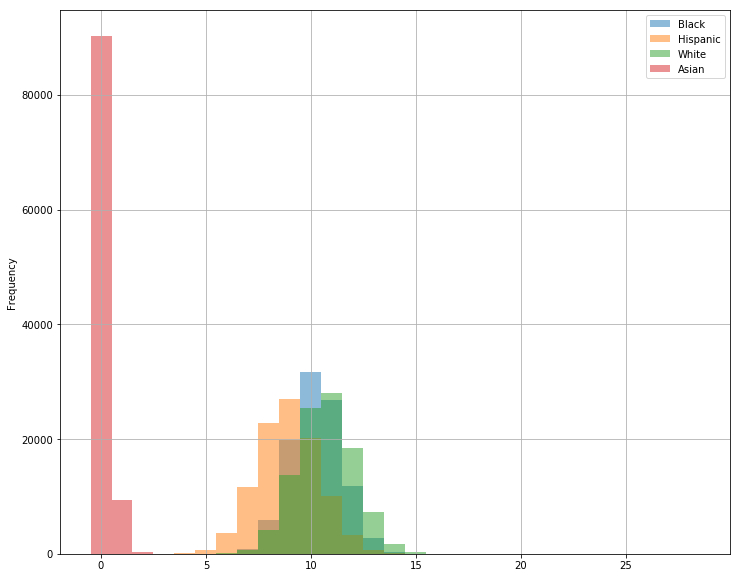

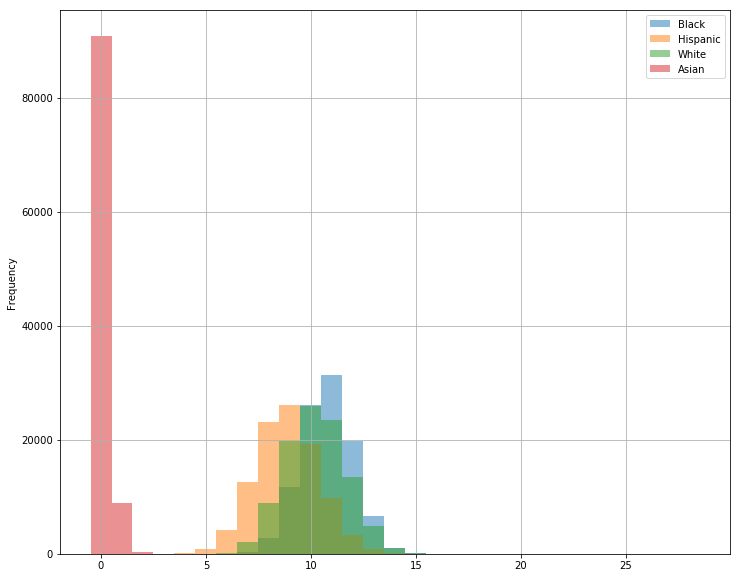

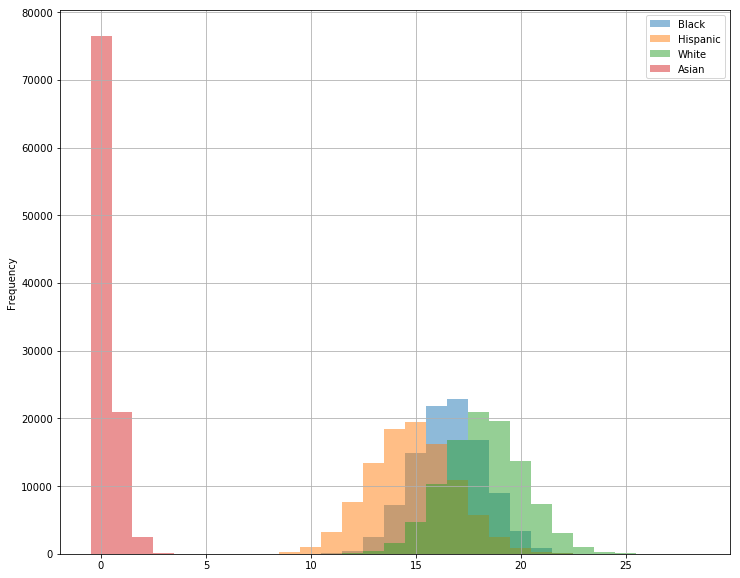

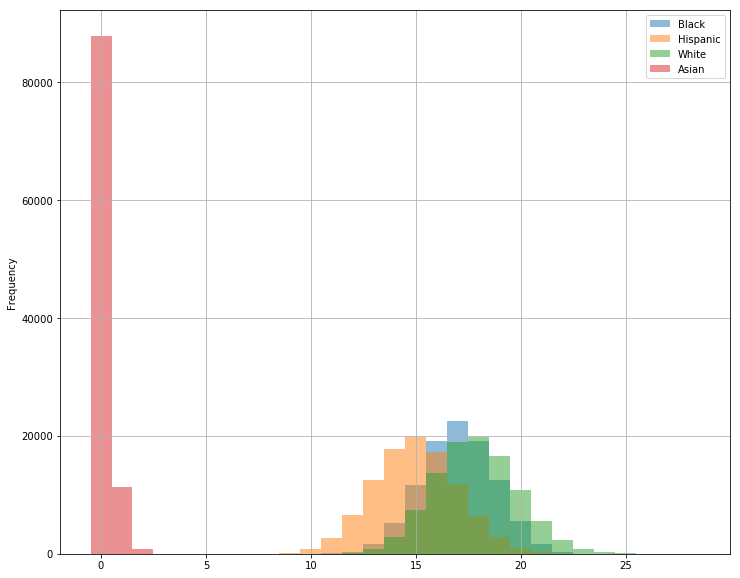

(<Figure size 864x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x23b661bccf8>)

In [36]:
plot_hist_superimposed("./projection_50x1.csv", "./50x1_hist_superimposed.png")
plot_hist_superimposed("./projection_10x3.csv", "./10x3_hist_superimposed.png")
plot_hist_superimposed("./projection_10x3_CA.csv", "./10x3_CA_hist_superimposed.png")
plot_hist_superimposed("./projection_10x5.csv", "./10x5_hist_superimposed.png")
plot_hist_superimposed("./projection_10x5_CA.csv", "./10x5_CA_hist_superimposed.png")

## Statistics

We can use `pandas` to compute statistics for the projected outcomes:

In [ ]:
outcomes_prec50.mean()